# Ultimate Data Science Challenge

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


## Part 1 - Exploratory Data Analysis

In [168]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [170]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


The data looks fine with no missing values. Dates range from January to April 13, both 1970.

In [146]:
# Turn login time into index
df.index = df.login_time
df.drop('login_time',axis=1,inplace=True)
# Create new column to count logins in 15 minute intervals
df['login_count'] = 1
df = df.resample('15T').sum()

In [160]:
df.head()

,login_count,weekday,time,hourly_count
login_time,,,,
1970-01-01 20:00:00,2,Thursday,20:00,24.0
1970-01-01 20:15:00,6,Thursday,20:15,NaN
1970-01-01 20:30:00,9,Thursday,20:30,NaN
1970-01-01 20:45:00,7,Thursday,20:45,NaN
1970-01-01 21:00:00,1,Thursday,21:00,9.0


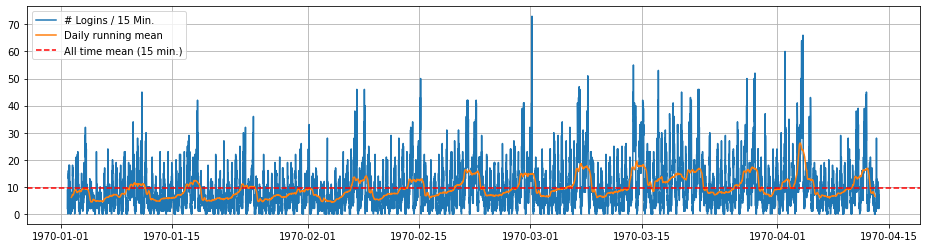

In [167]:
N = 4*24
N_mean = np.convolve(df['login_count'].values, np.ones((N,))/N, mode='valid')
plt.figure(figsize=(16,4))
sns.lineplot(data=df['login_count'],label='# Logins / 15 Min.')
plt.plot(df.index[int(N/2):-int(N/2)+1],N_mean, label='Daily running mean')
plt.grid()
plt.axhline(np.mean(df['login_count']),linestyle='--',color='r',label='All time mean (15 min.)')
plt.legend()

The first look at the data shows that we have daily and also weekly cycles. The weekly logins increased between January and March and consitently show high values for the 2nd half of the data set. To investigate the daily and weekly cycle further, let's look first at the mean hourly login counts over a week.

In [148]:
# Create column for weekday and time
df['weekday'] = [x.strftime('%A') for x in df.index]
df['time'] = [x.strftime('%H:%M') for x in df.index]
# Resample the data over one hour
df['hourly_count'] = df['login_count'].resample('60T').sum()
df.head()

,login_count,weekday,time,hourly_count
login_time,,,,
1970-01-01 20:00:00,2,Thursday,20:00,24.0
1970-01-01 20:15:00,6,Thursday,20:15,NaN
1970-01-01 20:30:00,9,Thursday,20:30,NaN
1970-01-01 20:45:00,7,Thursday,20:45,NaN
1970-01-01 21:00:00,1,Thursday,21:00,9.0


In [151]:
# Create new data set with the mean weekly data
df_hourly = df.drop('login_count',axis=1).groupby(['weekday','time']).mean()

In [156]:
# Drop rows with NaN's
df_hourly.dropna(inplace=True)
df_hourly.reset_index(inplace=True)
df_hourly.drop('index',axis=1,inplace=True)
df_hourly.head()

,weekday,time,hourly_count
0,Friday,00:00,65.000000
1,Friday,01:00,63.800000
2,Friday,02:00,51.400000
3,Friday,03:00,33.466667
4,Friday,04:00,23.533333


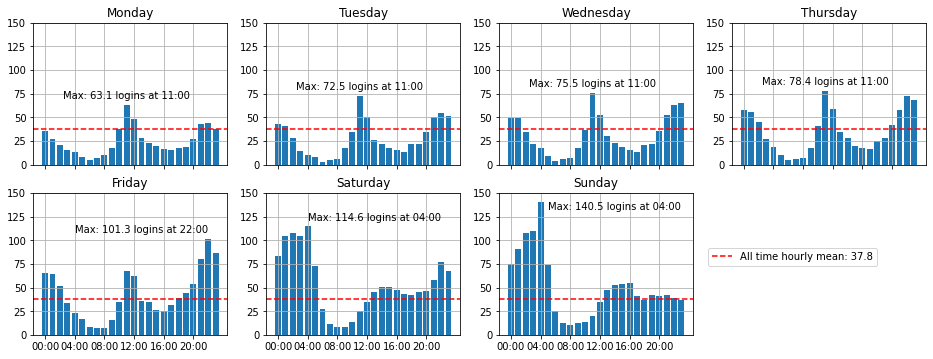

In [171]:
# Plot the data per day and hour
plt.figure(figsize=(16,12))
ylim = 150
k=1
label_str = 'Max: {:.1f} logins at {}'
all_mean = df_hourly['hourly_count'].mean()
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    ax = plt.subplot(4,4,k)
    # Filter for weekday
    bool_day = df_hourly['weekday']==day
    # Get time and count for the day
    temp = df_hourly.loc[bool_day,'time']
    temp_count = df_hourly.loc[bool_day,'hourly_count']
    plt.bar(temp,temp_count)
#     sns.catplot(x='time',y='hourly_count',data=df_hourly.loc[bool_day,:],kind='bar',legend_out=True,ax=ax)
    # plot the mean of all data as reference
    plt.axhline(all_mean,color='r',linestyle='--', label = 'All time hourly mean: {:.1f}'.format(all_mean))
    # identify best position for text box labeling
    max_count = max(temp_count)
    max_temp = temp.iloc[np.argmax(temp_count)]
    if np.argmax(temp_count) > 16:
        ha_str = 'right'
    elif np.argmax(temp_count) <7 :
        ha_str = 'left'
    else:
        ha_str = 'center'
    if max_count < (ylim - 20):
        xytext = (np.argmax(temp_count), max_count+15)
    else:
        xytext = (np.argmax(temp_count)+1, max_count)
    plt.annotate(label_str.format(max_count,max_temp), xy=(np.argmax(temp_count),max_count), xytext=xytext,ha=ha_str, va='top')
    # Set the other figure properties
    plt.ylim([0,ylim])
    plt.title(day)
    plt.grid()
    ax.set_xticks(np.arange(0,24,4))
    if k < 5:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(temp.iloc[0:None:4])
    if k == 7:
        plt.legend( bbox_to_anchor=(1.05, 0.65), loc='upper left')
    k+=1
    del max_count, max_temp, temp_count, temp, bool_day

The figure shows that:
- That there is a strong discrepancy between weekdays and weekends, namely: 
    1. Weekdays usually peak around 11 am and have a second peak aroung midnight.
    2. Weekends peak in the early morning hours (around 4 am) and only drop below the weekly mean in the morning (between 6am and noon).
    2. Activity is much lower during the week than during the weekend.
- The hourly mean is beaten and underscored everyday.
- In the mean, there is ALWAYS activity on the webpage.
    

## Part 2 - Experiment and metrics design
### The Situation
Two neighboring cities, Gotham and Metropolis, with complementary circadian rhythms do not share driver partners due to the two-way toll bridge that connects the cities. To encourage driver partners to be available in both cities, the Ultimate managers of city operations proposed to reimburse the toll costs for these drivers.

### Key measure of success
To measure the success of the toll reimbursement on the activity of driver partners in both cities, I would first see, if there is data available about past toll payments by driver partners. **If we have past data**, I would roll out the reimbursement test to all drivers and monitor their behaviour for at least one month to allow for other factors like festivities, weekdays, weather, etc. to *cancel out* in the analysis. **The key measure** should be number of crossings with passengers per driver partner. This would allow to identify whether the reimbursement is a sufficient incentive to stimulate business between the cities. Additional monitoring could include the direction, the time and date, and the number of customers per partner driver. Each partner driver should also identify their city of registration, the daily hours of operation and the daily number of customers. This would allow to identify other factors, such as the percentage of travelers between cities compared to within cities, most frequented hours and most common routes. But these are beneficial data to investigate the potential of further measures. **If we do not have past data**, we need to make an AB-test with a control group that is not being reimbursed and a treatment group that receives the reimbursement. It is important to pre-define these groups and inform the treatment group about the reimbursement. The desired change in bridge crossing frequency (e.g. +20%) will determine the size of the two test groups. The key measure and additional measures remain the same.

### Practical experiment
Assuming that we have an existing record for the bridge crossing by driver partners, the **first step** would be to analyze the past data to obtain statistics about the crossing frequency of the driver partners and preferably about the general activity of the driver partners (e.g. hours of opperations, number of customers, ...) . This will allow us to quantify our desired threshold for success, e.g. an increase of 25%, and the size of our test group. The **second step** would be to reach out to all driver partners (agencies, platforms, etc.) and inform them about the reimbursement test phase. Ideally, the drivers would need to register for the test phase to obtain more data. But this should only be considered if a potential selective side effect is negligible. The test phase should have a clear starting and a predefined criterium for the ending date, like at least 4 weeks time and 100'000 bridge crossings. This also depends on the sample size of the existing data and the minimum increase that defines success. Once the criteriem for the ending date is met, the **third step** involves the collection, cleaning and analysis of the data.

**As statistical test**, I would calculate the positive p-value with the null hypothesis being *the reimbursement has no effect*. The p-value will tell us if the difference is statistically significant. Additionally, the null hypothesis should not be in our confidence interval.

There are **3 potential outcomes**: 
1) **There is no significant effect or even a negative effect on the number of bridge crossings by partner drivers.** This would mean that the measure is not successful for the stimulation of inter-city business and therefore the reimbursement is a loss of investment. Additional data should be analyzed to identify potential other measures to stimulate the partner driver's behavior. For now the recommendation to the city operation would be to not reimburse the partner drivers.
2) **There is only a small, but significant, increase of bridge crossings by partner drivers.** The data should be carefully assessed to identify potential caveats in the setup of the experiment: Did we measure for long enough? Are our samples representative? ...? Then, it should be carefully assessed whether the small increase is enough for the financial investment of the reimbursement. I would recommend the city operations to potentially adapt the data collection and test setup to new insights and prolongue the test phase while being transperant about the costs and benefits of the prolongued study.
3) **There is a significant increase of bridge crossings by partner drivers.** After having double checked the data and measures, the recommendation to the city operations would be to officially introduce the reimbursement for partner drivers. The analysis and presentation should also include economical investment and benefit.

# Part 3 - Predictive Modeling

In [175]:
%reset -f
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [177]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are some missing values for the **avg_rating of_driver**, **avg_rating_by_driver** and the **phone**. We will need to investigate further, whether this is crucial information.

In [180]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [183]:
for var in ['city','phone','ultimate_black_user']:
    print(df[var].value_counts())

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
iPhone     34582
Android    15022
Name: phone, dtype: int64
False    31146
True     18854
Name: ultimate_black_user, dtype: int64


### Explore the data

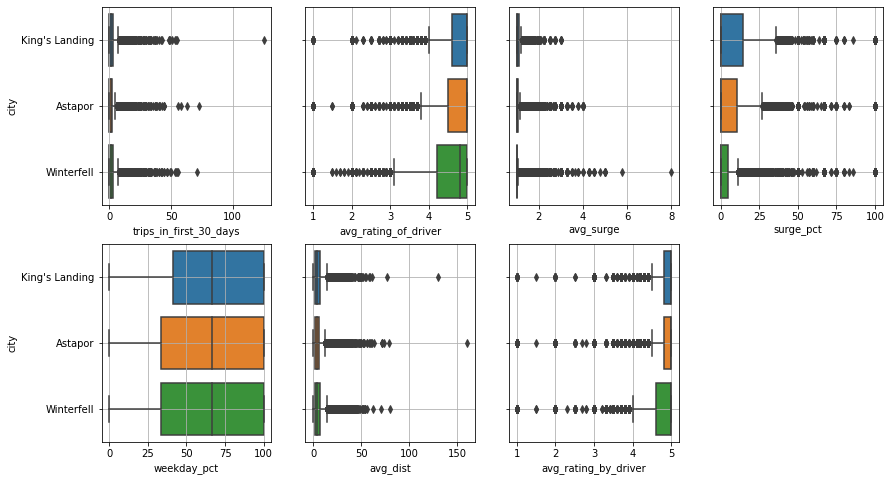

In [214]:
k = 1
plt.figure(figsize=(14,8))
for var in df.columns:
    if df[var].dtype in ['O','bool','<M8[ns]']:
        continue
    plt.subplot(2,4,k)
    s = sns.boxplot(y='city',x=var,data=df)
    if k not in [1,5]:
        s.set(ylabel=None)
        s.set(yticklabels=[])    
    plt.grid()
    k+=1

We can see that there are city specific characteristics, such as higher **surge_pct** for King's Landing compared to Winterfell, whereas the ratings, both by and of the driver, have a higher variation in Winterfell, which has also more records (see above).

In [226]:
df.loc[:,'ultimate_black_user'] = ['yes' if x==1 else 'no' for x in df['ultimate_black_user']]
df.loc[:,'last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df.loc[:,'signup_date'] = pd.to_datetime(df['signup_date'])

Replace the missing values either with the mean or *unknown*.

In [241]:
for var in ['avg_rating_of_driver','avg_rating_by_driver']:
    df[var].fillna(df[var].mean(),inplace=True)
df.phone.fillna('unknown',inplace=True)

Drop some outliers.

In [242]:
df.drop(df.index[df['trips_in_first_30_days']>100],inplace=True)
df.drop(df.index[df['avg_surge']>6],inplace=True)
df.drop(df.index[df['avg_dist']>100],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49996 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49996 non-null  object        
 1   trips_in_first_30_days  49996 non-null  int64         
 2   signup_date             49996 non-null  object        
 3   avg_rating_of_driver    49996 non-null  float64       
 4   avg_surge               49996 non-null  float64       
 5   last_trip_date          49996 non-null  datetime64[ns]
 6   phone                   49996 non-null  object        
 7   surge_pct               49996 non-null  float64       
 8   ultimate_black_user     49996 non-null  object        
 9   weekday_pct             49996 non-null  float64       
 10  avg_dist                49996 non-null  float64       
 11  avg_rating_by_driver    49996 non-null  float64       
 12  active_user             49996 non-null  object

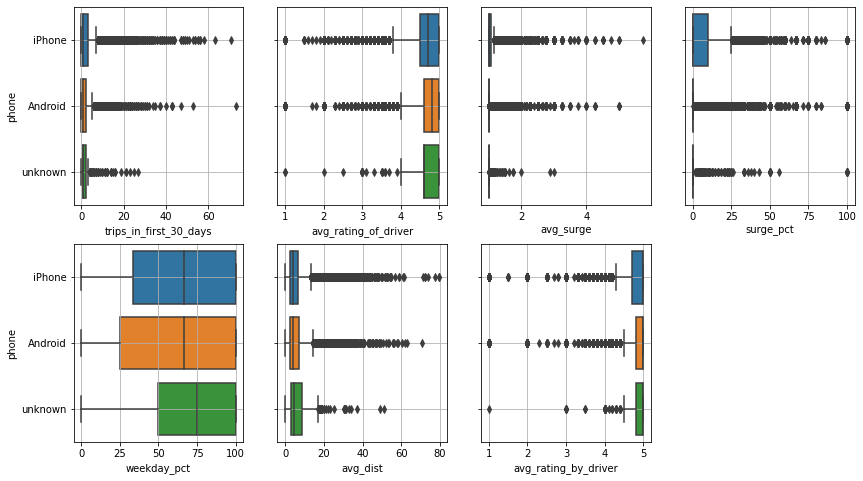

In [244]:
k = 1
plt.figure(figsize=(14,8))
for var in df.columns:
    if df[var].dtype in ['O','bool','<M8[ns]']:
        continue
    plt.subplot(2,4,k)
    s = sns.boxplot(y='phone',x=var,data=df)
    if k not in [1,5]:
        s.set(ylabel=None)
        s.set(yticklabels=[])
    
    plt.grid()
    k+=1

In respect to the phone type, there seems to be little difference and it is questionable if this feature will be relevant or not. Since it has missing values, it still needs to be determined how to best fill these.

### Define the target variable *active_user*

In [236]:
most_recent = max(df['last_trip_date'])
df['active_user'] = ['yes' if (most_recent-x).days <= 30 else 'no' for x in df['last_trip_date']]

In [269]:
# add another variable showing how long a user is a member
df['days_since_signup'] = [(most_recent-x).days for x in df['signup_date']]

In [ ]:
# make sure that index is still continuous
df = df.reset_index()
df.drop('index',axis=1,inplace=True)
df.info()

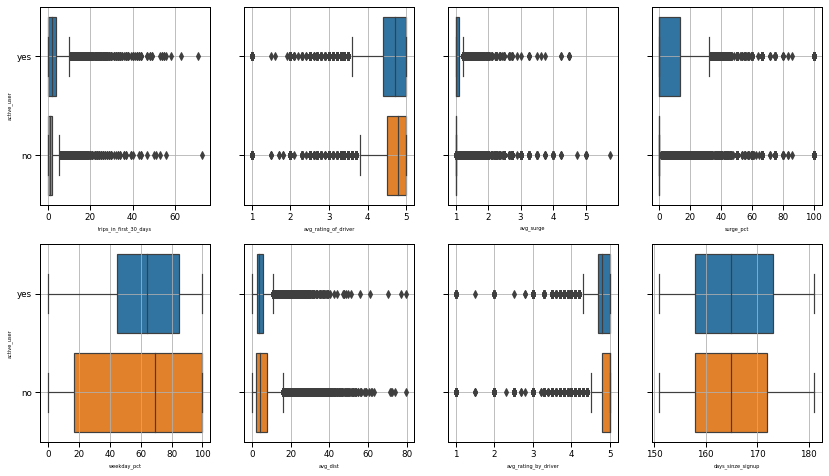

In [270]:
k = 1
plt.figure(figsize=(14,8))
for var in df.columns:
    if df[var].dtype in ['O','bool','<M8[ns]']:
        continue
    plt.subplot(2,4,k)
    s = sns.boxplot(y='active_user',x=var,data=df)
    if k not in [1,5]:
        s.set(ylabel=None)
        s.set(yticklabels=[])
    
    plt.grid()
    k+=1

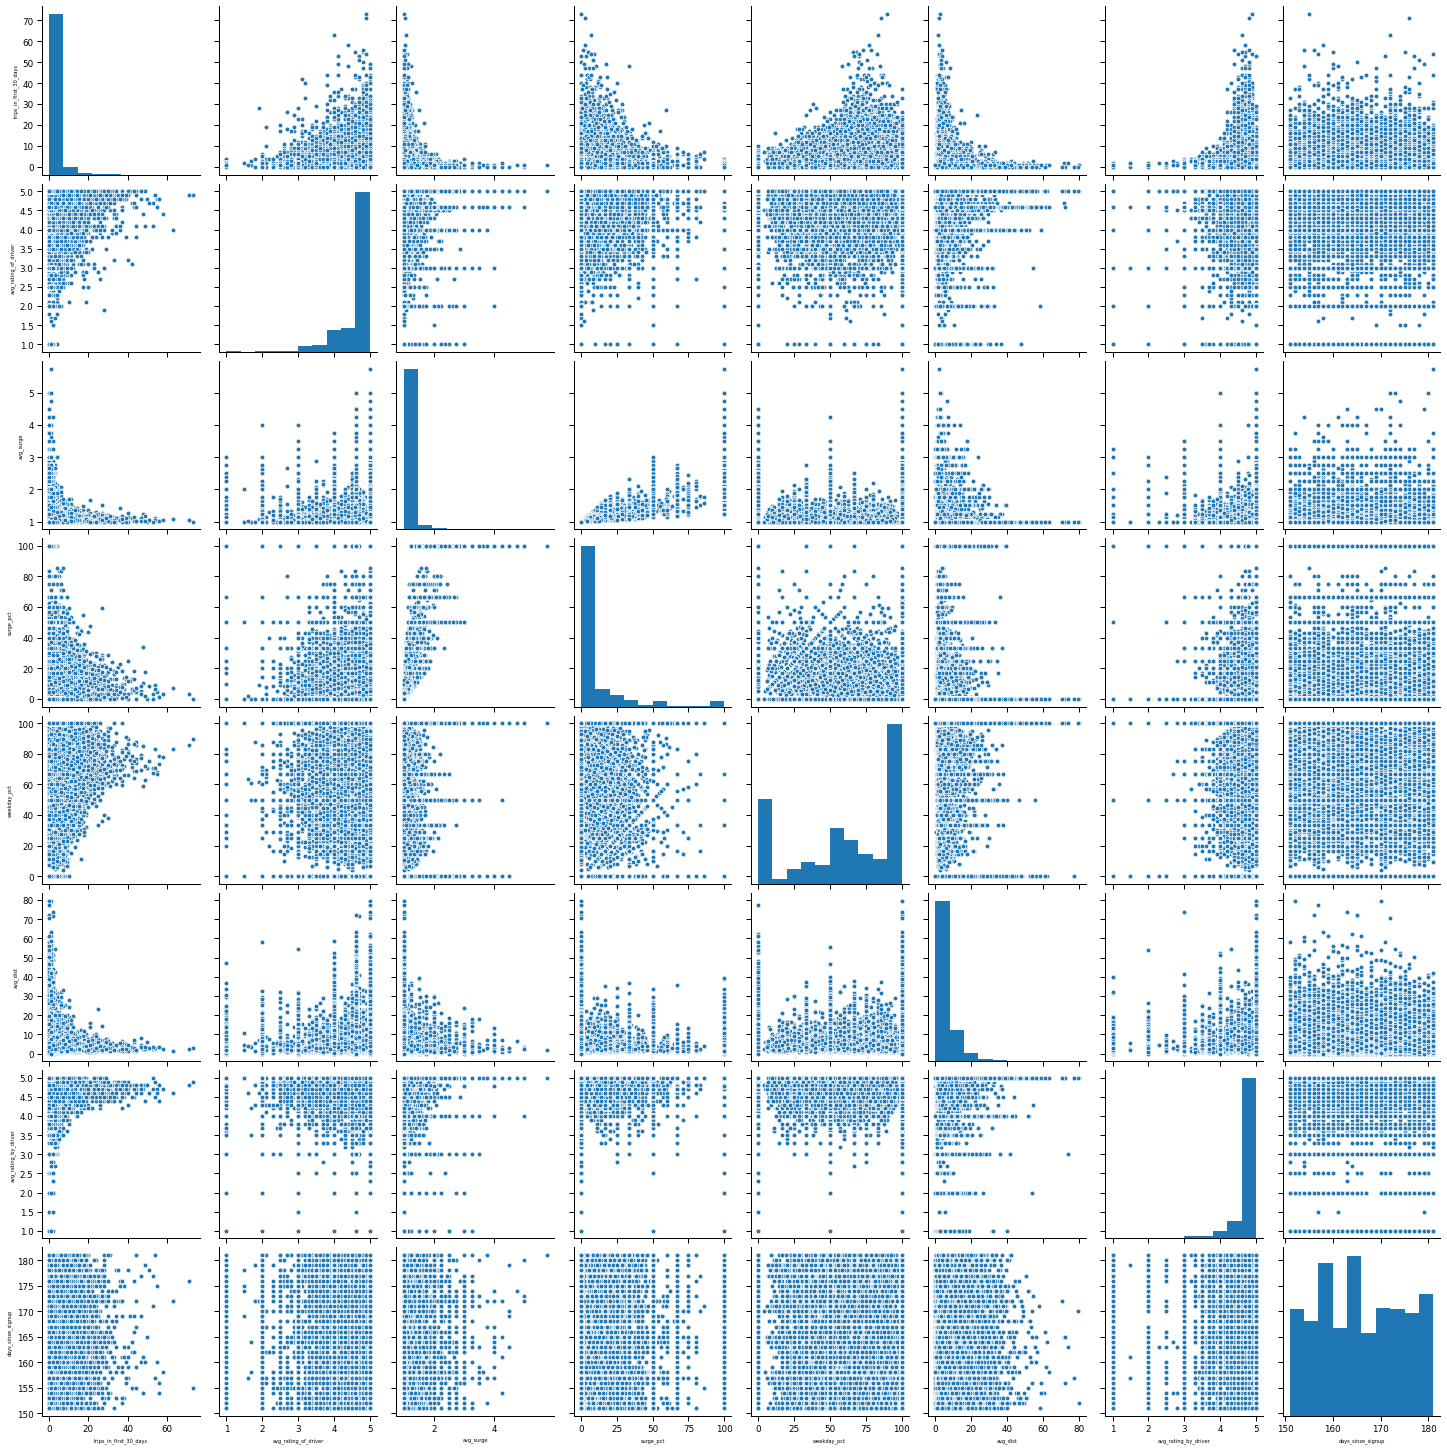

In [271]:
sns.pairplot(data=df) # 

This diagram shows that ** trips_in_first_30_days** correlates with rating, distance, and somewhat with week_pct. There appear to be a couple of common ratings, and percentages applied. Note the using **active_users** as hue did not show any clear discrepancies and was skipped for clarity.

### Standardize values and calculate correlation matrix

In [272]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop(['city','signup_date','last_trip_date','phone','ultimate_black_user','active_user'],axis=1).values)
normalized_df = scaler.transform(df.drop(['city','signup_date','last_trip_date','phone','ultimate_black_user','active_user'],axis=1).values)

In [273]:
normalized_df = pd.DataFrame(normalized_df,columns=df.drop(['city','signup_date','last_trip_date','phone','ultimate_black_user','active_user'],axis=1).columns)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

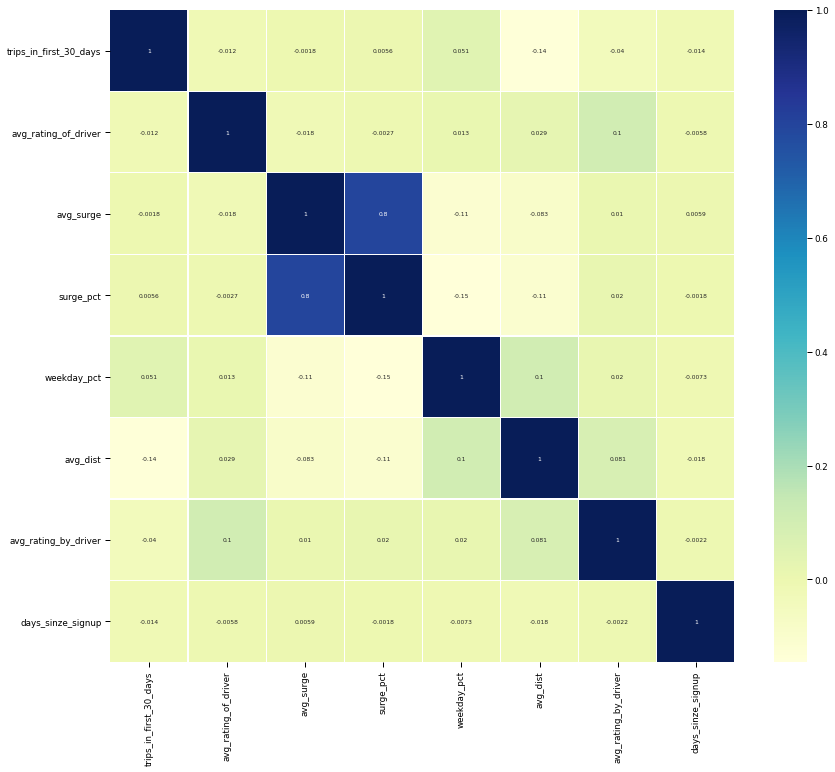

In [274]:
plt.figure(figsize=(14,12))
sns.heatmap(normalized_df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
sns.set_context("paper", rc={"font.size":6,"axes.titlesize":6,"axes.labelsize":5}) 
plt.yticks(rotation=0)

The above heat matrix shows that except for the surge the given features do not linearly correlate. 

Next, let's create dummy features for the categories.

In [275]:
normalized_df = pd.concat([normalized_df, pd.get_dummies(df.loc[:,['city','phone']])], axis=1)
# make sure that there are no empty values
for var,i in zip(['phone_iPhone','phone_Android','phone_unknown'],[0,0,1]):
    normalized_df[var].fillna(i,inplace=True)
for var in ['city_Astapor',"city_King's Landing",'city_Winterfell']:
    normalized_df[var].fillna(0,inplace=True)
normalized_df.dropna(inplace=True)

normalized_df['black_user'] = [1 if x == 'yes' else 0 for x in df.loc[:,'ultimate_black_user']]
normalized_df['active_user'] = [1 if x == 'yes' else 0 for x in df.loc[:,'active_user']]

In [319]:
normalized_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_sinze_signup,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown,black_user,active_user
0,0.459422,0.174170,0.115239,0.328338,-0.397120,-0.376260,0.497687,-0.965835,0.0,1.0,0.0,0.0,1.0,0.0,1,1
1,-0.606437,0.705368,-0.338947,-0.443392,-0.294641,0.437872,0.497687,-1.422785,1.0,0.0,0.0,1.0,0.0,0.0,0,0
2,0.192957,-0.534094,-0.338947,-0.443392,1.053767,-0.890635,0.497687,1.204674,1.0,0.0,0.0,0.0,1.0,0.0,0,0
3,1.791745,-0.002896,0.296913,0.558855,0.514404,-0.608615,0.273353,0.747725,0.0,1.0,0.0,0.0,1.0,0.0,1,1
4,3.124068,-0.357028,0.524006,0.147934,0.579127,-0.472040,0.273353,-1.194310,0.0,0.0,1.0,1.0,0.0,0.0,0,0


In [326]:
print('Percentage of active users in the data set: {:.1f}%'.format(normalized_df.active_user.sum()/len(normalized_df.active_user.values)*100))

Percentage of active users in the data set: 37.6%


## Explore the data set by means of clustering

In [320]:
X = normalized_df.drop('active_user',axis=1).values

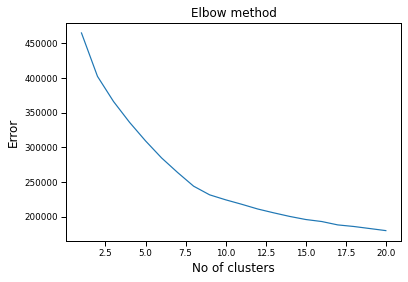

In [327]:
from sklearn.cluster import KMeans
Error =[]
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 21), Error)
plt.title('Elbow method',fontsize=12)
plt.xlabel('No of clusters',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.show()

(8, 15)


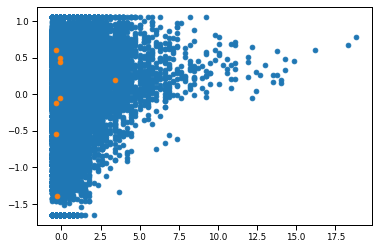

In [331]:
kmeans = KMeans(n_clusters = 8).fit(X)
centroids = kmeans.cluster_centers_
print(centroids.shape)

plt.scatter(X[:,0],X[:,4])
plt.scatter(centroids[:, 0], centroids[:, 4])

In [334]:
for i in range(8):
    print(i, ': ',sum(normalized_df['active_user'].loc[kmeans.labels_==i]))

0 :  5325
1 :  998
2 :  1175
3 :  2794
4 :  555
5 :  230
6 :  1781
7 :  5944


Clustering did not produce **one** dominant cluster containing all active users. Therefore it is questionable if it adds any more insight or value to this analysis.

## Prepare for modeling

In [340]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(normalized_df.drop('active_user',axis=1),normalized_df['active_user'],test_size=0.25,stratify=normalized_df['active_user'],random_state=42)

## Explore different models

We start with the classical **Logistic Regression** model for our classification problem (*active* or *non-active*). As primary measures, *mean square error* and *R2-score* are chosen. Further analysis includes the *confusion matrix* and the *p-value*.

In [371]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(random_state=0)
lreg.fit(X_train,y_train)
y_pred = lreg.predict(X_test)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))

Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.6755740459236739
Recall [(TP)/(TP+FN)]: 0.30127659574468085
Precision [TP/(TP+FP)]: 0.6474622770919067


While our accuracy is not *that bad*, the low recall value tells us that the *active users* are underpredicted.

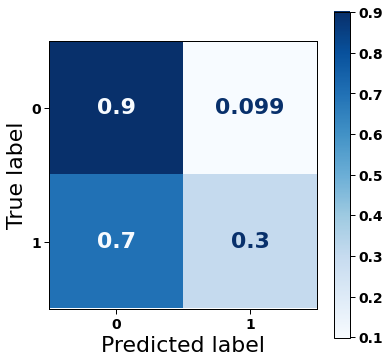

In [366]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib as mpl
font = {'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
fig = plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(lreg, X_test, y_test,cmap=plt.cm.Blues,normalize='true',ax=fig.gca())

We learn that the model is able to predict 90% of the non-active customers, but only 30% of the active customers correctly. 

In our case, it is most important to distinguish well between the active and non-active users. Misclassification is not as severe than when dealing with e.g. cancer patients where you may not miss a single positive result. Therefore the aim of the modeling section is to find a model (and parameterisation) that best predicts the general distribution of data which is measured with the accuracy. Recall and precision will provide further insight into the nature of the result.

### Random Forest Classifier

In [372]:
from sklearn.ensemble import RandomForestClassifier
regressor = RandomForestClassifier(random_state=0, n_estimators=200)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))

Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.7368589487158973
Recall [(TP)/(TP+FN)]: 0.5925531914893617
Precision [TP/(TP+FP)]: 0.669632123106516


This is a much improved result, but let's see if we cannot hypertune the model parameters to improve the result even more.

In [388]:
param_grid = {"n_estimators": [150,200],
 "max_depth": [3, None],
 "max_features": [3, 6, None],
 "min_samples_split": [2, 5],
 "min_samples_leaf": [1, 3],\
 "bootstrap": [True, False]}
rfc = RandomForestClassifier(random_state=0)
grid_forest = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv=3,scoring='accuracy')
grid_forest.fit(X_train.values, y_train)
print('Best score: ',grid_forest.best_score_)
print('Best set of parameters: ' ,grid_forest.best_params_)
y_pred = grid_forest.predict(X_test.values)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))

Best score:  0.7502733552017494
Best set of parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.7483798703896312
Recall [(TP)/(TP+FN)]: 0.5736170212765958
Precision [TP/(TP+FP)]: 0.7026322647902007


In [390]:
from sklearn.ensemble import RandomForestClassifier
regressor = RandomForestClassifier(random_state=0, n_estimators=200,max_features=3,min_samples_leaf=3,min_samples_split=2,bootstrap=True,max_depth=None)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))

Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.7483798703896312
Recall [(TP)/(TP+FN)]: 0.5736170212765958
Precision [TP/(TP+FP)]: 0.7026322647902007


In [395]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)

ind = argsort(regressor.feature_importances_)
labels = []
sizes = []
print('Feature Importance:')
for i in ind:
    if 100*regressor.feature_importances_[i] < 3:
        if 'other' not in labels:
            labels.append('other')
            sizes.append(100*regressor.feature_importances_[i])
        else:
            sizes[labels=='other']+=100*regressor.feature_importances_[i]
    else:
        labels.append(X_train.columns[i])
        sizes.append(100*regressor.feature_importances_[i])
    print('{} : {:.1f}%'.format(X_train.columns[i],100*regressor.feature_importances_[i]))

Feature Importance:
phone_unknown : 0.0%
city_King's Landing : 0.8%
phone_iPhone : 0.8%
phone_Android : 0.8%
city_Astapor : 0.9%
city_Winterfell : 1.0%
black_user : 5.3%
avg_rating_of_driver : 6.5%
trips_in_first_30_days : 8.4%
avg_surge : 8.7%
days_sinze_signup : 10.9%
surge_pct : 10.9%
avg_rating_by_driver : 13.9%
weekday_pct : 15.4%
avg_dist : 15.8%


The modeling shows that the kind of phone or the city are not important features to determine whether a user remains active. **Important features are the average distance, the weekday percentage, average rating by driver, surge percentage and the days since the signup date**. The preliminary analysis above has shown that compared to inactive users, active users drive on average shorter distances, have a greater variation in rating by driver and surge percentage, and less variation in the weekday percentage. On average they are slightly longer members.

(-1.1023715642521201,
 1.1062852504028422,
 -1.1111611517831863,
 1.2110140348629772)

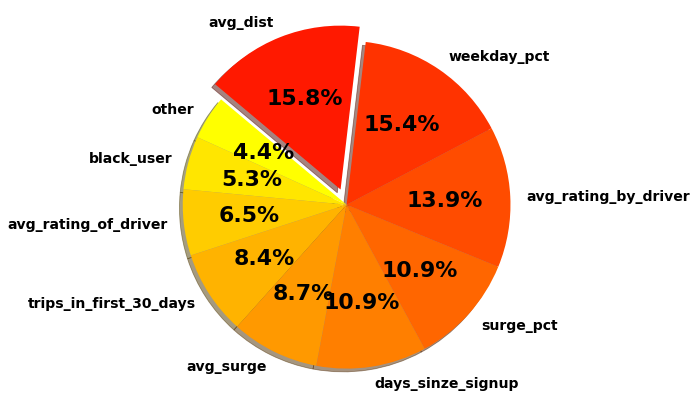

In [396]:
# Data to plot
explode = np.zeros(len(labels)) #(0.1, 0, 0, 0)  # explode 1st slice
explode[-1] = 0.1

# Plot
theme = plt.get_cmap('autumn_r')
fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
ax1.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True, startangle=140)



ax1.axis('equal')


### Gradient Boosting Classifier

Out of curiousity, let's try another model to see if the result can be further improved.

In [384]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42,n_estimators=200)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))

Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.7565405232418594
Recall [(TP)/(TP+FN)]: 0.5842553191489361
Precision [TP/(TP+FP)]: 0.7160365058670144


In [386]:
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators": [100, 150],
 "max_depth": [3, 6, None],
 "max_features": [3, 6, None],
 "min_samples_split": [2, 3],
 "min_samples_leaf": [1, 2]}
gbc = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(estimator=gbc, param_grid=param_grid, n_jobs=-1,cv=3,scoring='accuracy')

In [387]:
grid.fit(X_train, y_train)
print('Best score: ',grid.best_score_)
print('Best set of parameters: ' ,grid.best_params_)
y_pred = grid.predict(X_test)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))

Best score:  0.7577672880497106
Best set of parameters:  {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.757820625650052
Recall [(TP)/(TP+FN)]: 0.5982978723404255
Precision [TP/(TP+FP)]: 0.7117185522652493


In [392]:
gbc = GradientBoostingClassifier(random_state=42,n_estimators=150,max_depth=6,max_features=None,min_samples_leaf=2,min_samples_split=2)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('Accuracy [(TP+TN)/(TP+FP+TN+FN)]: ',accuracy_score(y_test,y_pred))
print('Recall [(TP)/(TP+FN)]:',recall_score(y_test,y_pred))
print('Precision [TP/(TP+FP)]:',precision_score(y_test,y_pred))
ind = argsort(gbc.feature_importances_)
labels = []
sizes = []
print('Feature Importance:')
for i in ind:
    if 100*gbc.feature_importances_[i] < 3:
        if 'other' not in labels:
            labels.append('other')
            sizes.append(100*gbc.feature_importances_[i])
        else:
            sizes[labels=='other']+=100*gbc.feature_importances_[i]
    else:
        labels.append(X_train.columns[i])
        sizes.append(100*gbc.feature_importances_[i])
    print('{} : {:.1f}%'.format(X_train.columns[i],100*gbc.feature_importances_[i]))

Accuracy [(TP+TN)/(TP+FP+TN+FN)]:  0.757820625650052
Recall [(TP)/(TP+FN)]: 0.5982978723404255
Precision [TP/(TP+FP)]: 0.7117185522652493
Feature Importance:
phone_unknown : 0.1%
city_Winterfell : 0.2%
phone_iPhone : 0.2%
city_King's Landing : 0.2%
phone_Android : 0.3%
city_Astapor : 0.3%
avg_rating_of_driver : 3.1%
days_sinze_signup : 3.1%
avg_surge : 4.5%
black_user : 6.6%
avg_dist : 7.3%
trips_in_first_30_days : 7.6%
surge_pct : 13.9%
weekday_pct : 15.8%
avg_rating_by_driver : 36.6%


The Gradient Boosting Classifier **is performing slightly better** in accurancy, recall and precision than the Random Forest Classifier. Interestingly, the important features are also weighed differently. The average rating by driver clearly outweighs the other features. The average distance, which was the most important feature in the RFC model, only comes 5th and has less than 10% importance.

(-1.1019047829555146,
 1.1183800918288667,
 -1.1166604185435183,
 1.216805663174121)

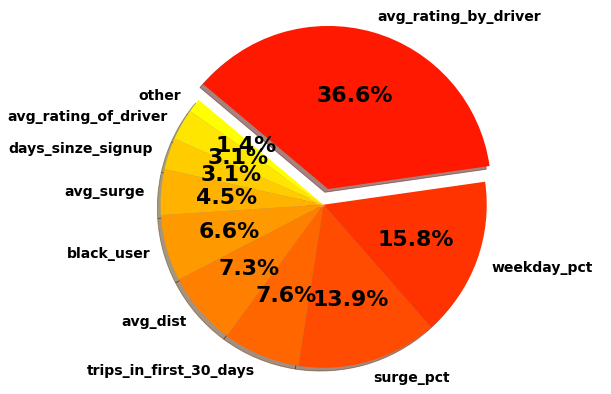

In [394]:
# Data to plot
explode = np.zeros(len(labels)) #(0.1, 0, 0, 0)  # explode 1st slice
explode[-1] = 0.1

# Plot
theme = plt.get_cmap('autumn_r')
fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
ax1.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True, startangle=140)



ax1.axis('equal')


## Conclusion
The model results suggest that the most important features are the average rating by the driver, the percentage of weekdays and the surge percentage. The figure below reveals that in-active customers obtained slightly worse average ratings by the driver. They also tend to either only drive in the weekend or only on weekdays and avoid surge.

These results give no clear insight into **one measure that would solve it all**. Based on the weekday percentage and the average distance traveled by the *inactive* users, I would classify most of them as people who had an intended purpose when using Ultimate and not just occassionally chose for the service. I would recommend making offers that animate regular usage, such as a discount for every xx miles driven or alike.





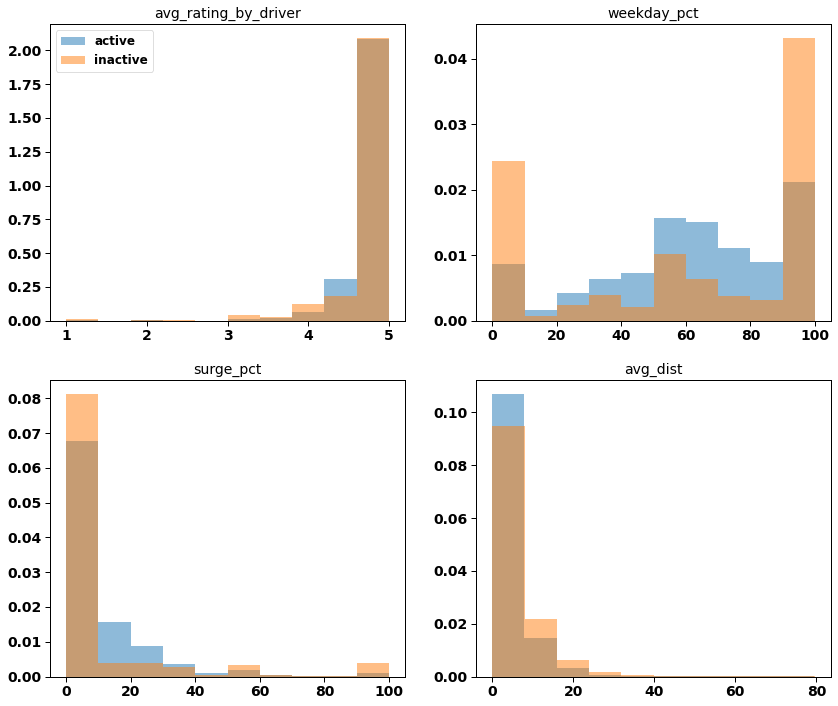

In [459]:
plt.figure(figsize=(14,12))
k = 1
bool_active = df['active_user']=='yes'
for var in ['avg_rating_by_driver','weekday_pct','surge_pct','avg_dist']:
    plt.subplot(2,2,k)
    plt.hist(df[var].loc[bool_active],bins=10,alpha=0.5,label='active',density=True)
    plt.hist(df[var].loc[~bool_active],bins=10,alpha=0.5,label='inactive',density=True)
    plt.title(var,fontdict={'fontsize':14})
    if k == 1:
        plt.legend()
    k+=1
    
